# Hotel Reservation

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations. 

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics. 

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Data Description
The data contains different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not. (This is the target column that we'd want to be able to predict). Use 'Canceled' as positive class and 'Not_Canceled' as negative class.

## 1) Importing necessary libraries and data

In [57]:
%load_ext nb_black

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# To tune a model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from utils import (
    col_out,
    model_summary,
    adj_r2_score,
    model_performance_regression,
    confusion_matrix_helper,
    model_performance_classification_sklearn,
)

import sklearn.metrics as metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config

set_config(display="diagram")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## 2) Perform Data Preprocessing and transformation. Make sure to not have data leakage. 

* Things considered:
- Missing value treatment (if needed)
- Feature engineering (if needed)
- One-hot encoding
- Any other preprocessing steps (if needed)

In [4]:
hotel_data = (
    pd.read_csv("/Users/manoj/OneDrive/Documents/Python Scripts/hotelReservation.csv")
    .rename(columns=lambda col: col.replace("'", "").replace("no_of_", ""))
    .dropna(
        subset=["adults", "weekend_nights", "room_type_reserved", "market_segment_type"]
    )
    .drop(
        ["Booking_ID", "Unnamed: 0"],
        axis=1,
    )
    .reset_index(drop=True)
)


hotel_data["booking_status"] = hotel_data["booking_status"].map(
    {"Canceled": 1, "Not_Canceled": 0}
)


# target columns
target = ["booking_status"]

# categorical columns
columns_categorical = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"]

# numerical and boolean columns (excluding the target columns ['rating', 'ratingOrdinal', 'ratingBinary'])
columns_numeric = list(
    set(list(hotel_data.select_dtypes(np.number).columns)) - set(target)
)
columns_numeric = list(hotel_data.select_dtypes("float").columns)


<IPython.core.display.Javascript object>

In [5]:
# column transformer (steps for data transformations, missing value imputation, transformation, scaling, and encoding)
col_transformer = make_pipeline(
    ColumnTransformer(
        transformers=[
            (
                "scale",
                Pipeline(
                    [
                        ("logTransform",
                            FunctionTransformer(
                                np.log1p, feature_names_out=col_out, validate=True)
                        ),
                        ("standardScale", StandardScaler()),
                    ]
                ),
                ["adults", "weekend_nights"],
            ),
            (
                "imputeOneHot",
                Pipeline(
                    [
                        (
                            "SimpleImpute",
                            SimpleImputer(
                                missing_values=np.NaN,
                                strategy="constant",
                                fill_value="is_missing",
                            ),
                        ),
                        ("oneHotEncode", OneHotEncoder(drop="first")),
                    ]
                ),
                columns_categorical,
            ),
        ],
        verbose_feature_names_out=False,
        remainder="passthrough",
    )
)


<IPython.core.display.Javascript object>

## 3) Build a default Decision Tree model. Evaluate the performance of your default Decision Tree model on the training and the test data set? State your observation on whether the model is overfit/underfit

In [6]:
# split the data into training and test sets before running them through the preprocessing pipeline
X = hotel_data.drop(target, axis=1)
y = hotel_data["booking_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# pipeline for Decision Trees

# using column transformer and pipeline help in avoiding data leakage.
decision_tree_pipeline = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("d_tree", DecisionTreeClassifier(random_state=42)),
    ]
)

decision_tree_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('scale',
                                                                   Pipeline(steps=[('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x000001318E916700>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('standardScale',
                                                                                    StandardScaler())]),
                                                                   ['adults',
                                                                    'weekend_nights']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(fill_value='is_missing',
                                                                                                  strategy='constant')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['type_of_meal_plan',
                                                                    'room_type_reserved',
                                                                    'market_segment_type'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', DecisionTreeClassifier(random_state=42))])

<IPython.core.display.Javascript object>

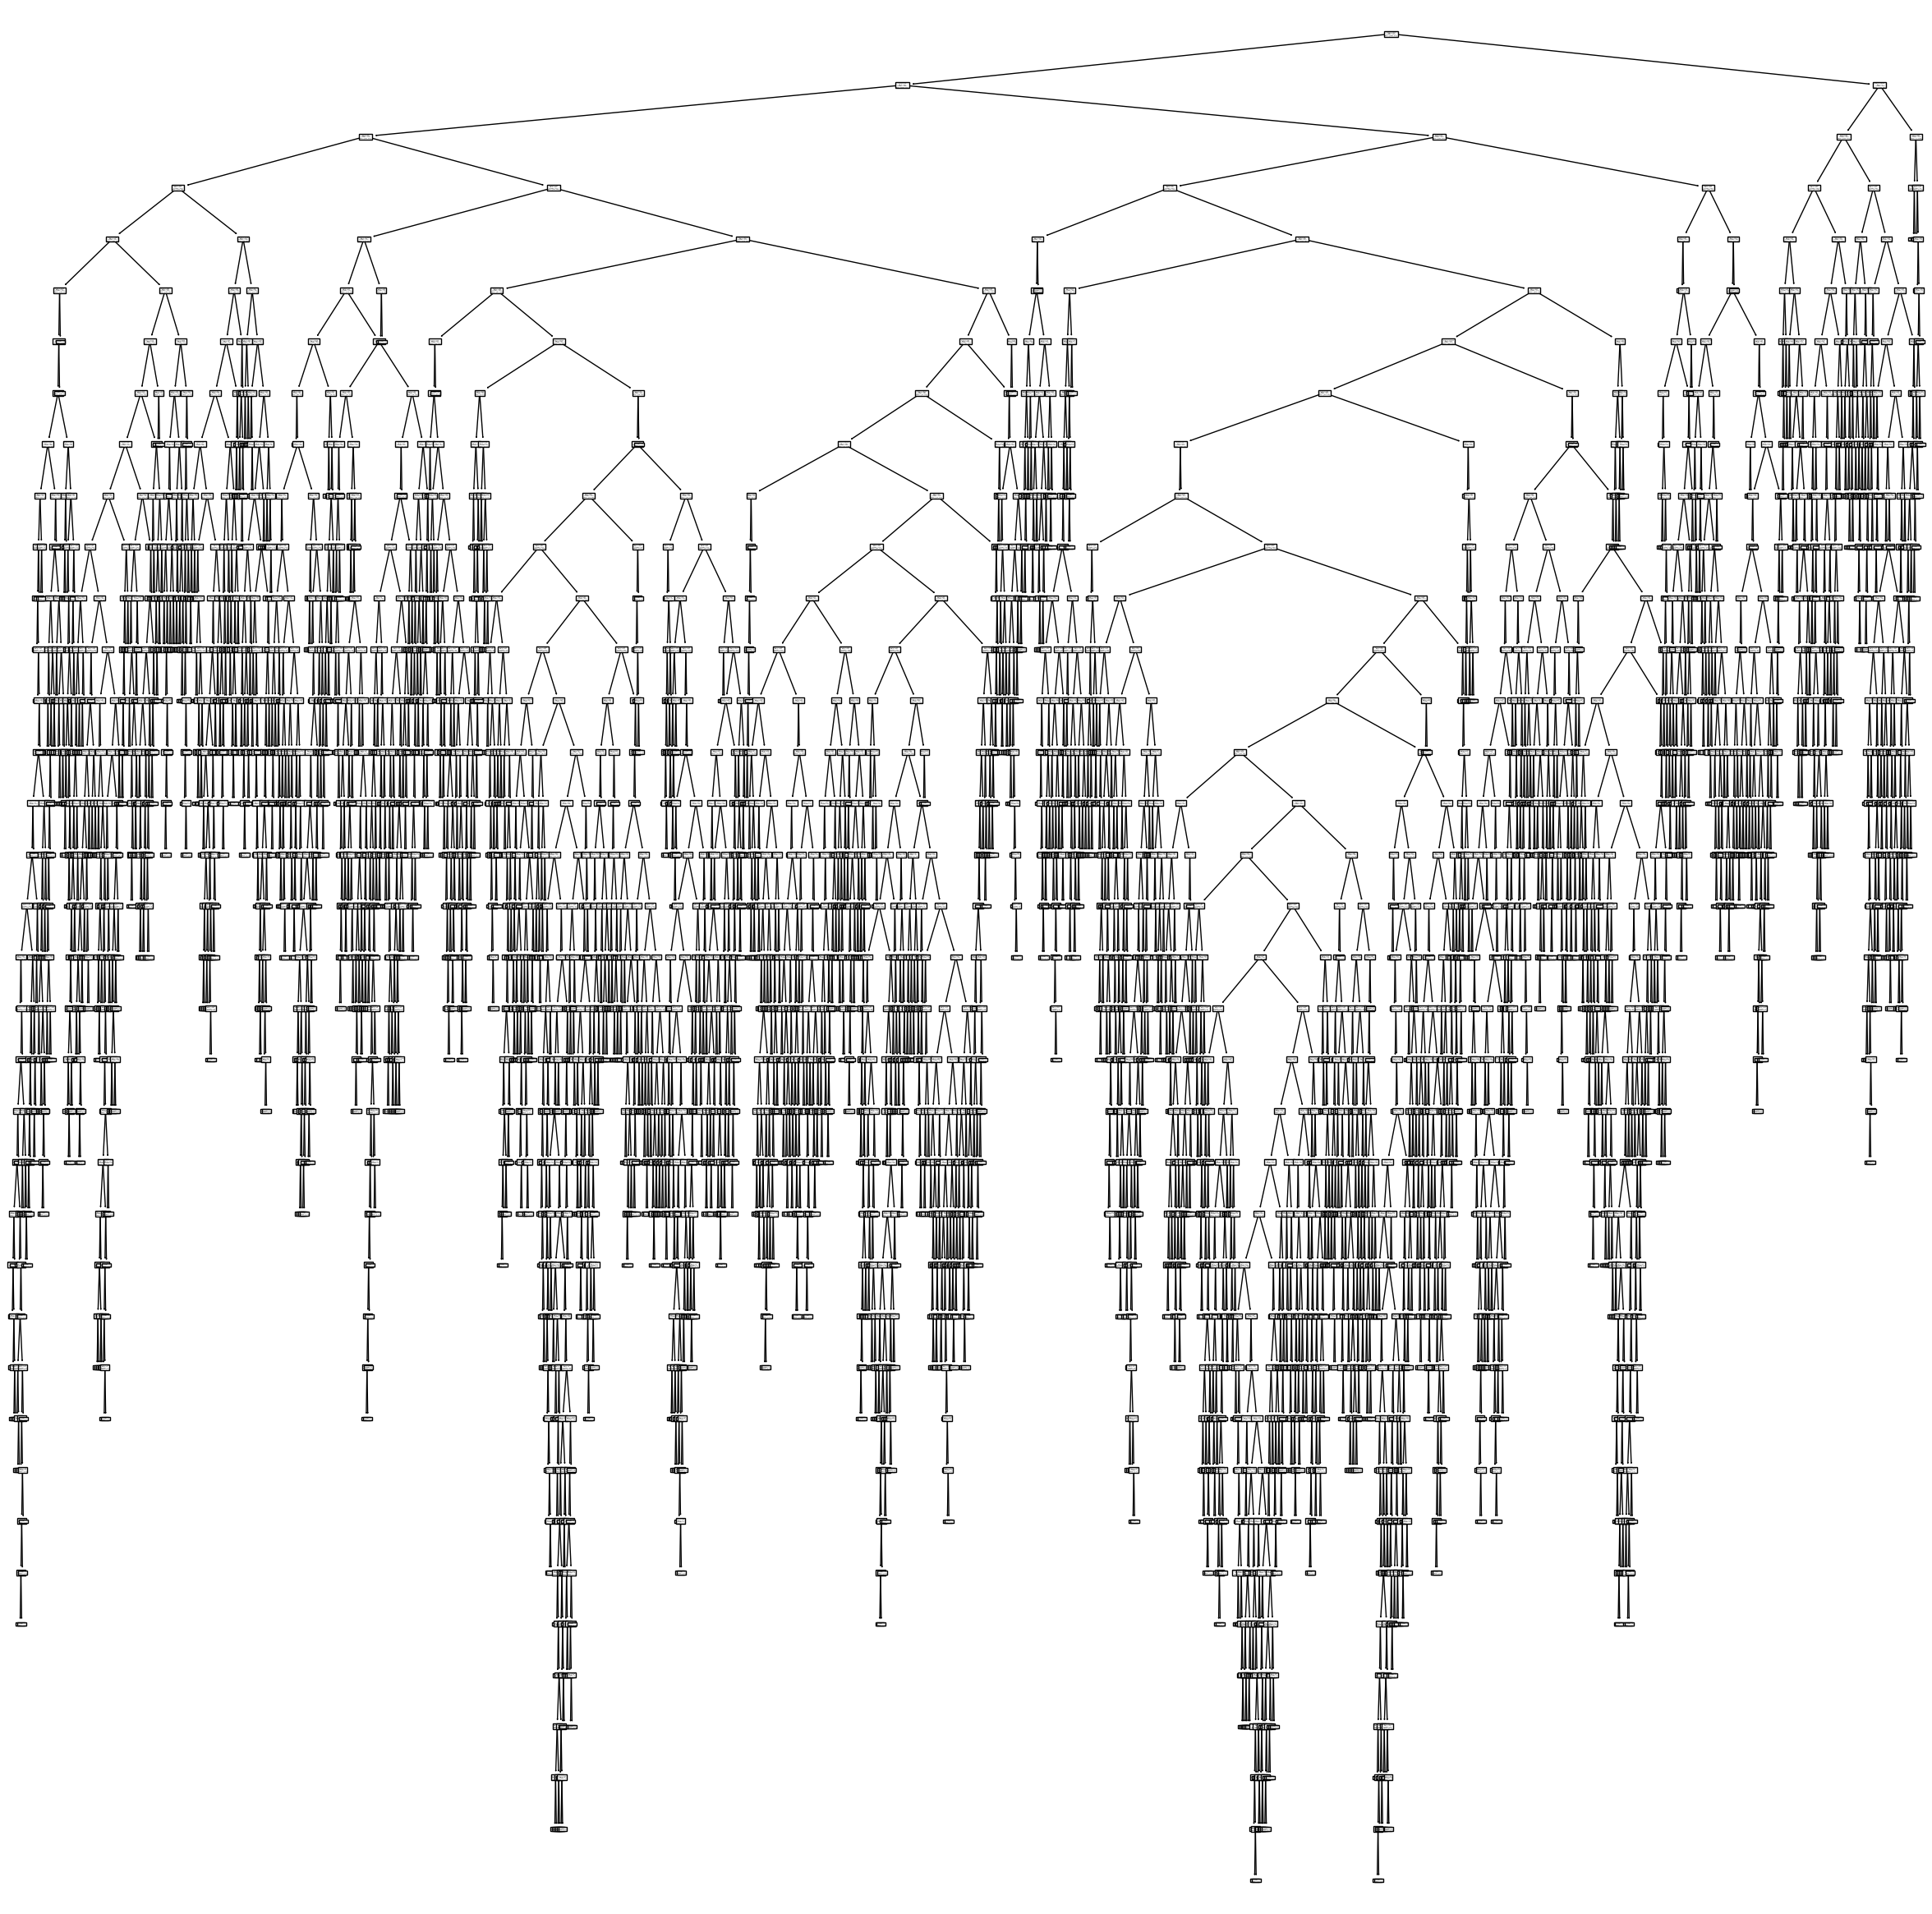

Wall time: 2min 11s


<IPython.core.display.Javascript object>

In [7]:
%%time

decision_tree_pipeline.fit(X_train, y_train)
plt.figure(figsize=(30, 30))
plot_tree(decision_tree_pipeline['d_tree'])
plt.show()

In [8]:
cross_val_score(decision_tree_pipeline, X_train, y_train, cv=10)

array([0.87712895, 0.85806975, 0.86780211, 0.85523114, 0.84712084,
       0.86171938, 0.86334144, 0.86131387, 0.86004057, 0.86085193])

<IPython.core.display.Javascript object>

In [9]:
cross_validate(decision_tree_pipeline, X_train, y_train, cv=10, scoring="f1")

{'fit_time': array([4.50261784, 4.57218027, 4.5442636 , 4.60635924, 4.7786479 ,
        4.65927005, 4.69354558, 4.72784328, 4.67455077, 4.65304613]),
 'score_time': array([0.00600052, 0.00700021, 0.0065155 , 0.00700068, 0.00800729,
        0.00700998, 0.006006  , 0.00700068, 0.00600863, 0.00599432]),
 'test_score': array([0.81376767, 0.7815231 , 0.79726368, 0.78271455, 0.77220544,
        0.79066912, 0.79235983, 0.78862794, 0.78504673, 0.79072605])}

<IPython.core.display.Javascript object>

In [10]:
cross_val_predict(decision_tree_pipeline, X_train, y_train, cv=10)

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>

In [15]:
# model performance on the training dataset
print("Evaluation metrics on the training dataset")
dt_train_perf = model_performance_classification_sklearn(
    decision_tree_pipeline, X_train, y_train, threshold=0.5
)
display(dt_train_perf)

# model performance on the testing dataset
print("Evaluation metrics on the testing dataset")
dt_test_perf = model_performance_classification_sklearn(
    decision_tree_pipeline, X_test, y_test, threshold=0.5
)
display(dt_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.994768,0.987245,0.996749,0.991974


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.867714,0.789945,0.802937,0.796388


<IPython.core.display.Javascript object>

Training Dataset: The model performs exceptionally well on the training dataset, achieving very high accuracy, recall, precision, and F1 scores. These high scores may indicate that the model has memorized the training data or is too complex, which could be a sign of overfitting
Testing Dataset: The model's performance on the testing dataset is significantly worse than on the training dataset. While the accuracy, recall, precision, and F1 scores are still decent, they are noticeably lower. This performance drop between the training and testing datasets is a sign of overfitting    

## 4) Tune the hyperparameters for the Decision tree and find the optimal set of hyperparamter. Use GridSearchCV technique. Use F1 score as your main scorer for the optimization. Evaluate the performance of the best model from your gridsearchCV on the training and the testing dataset

In [63]:
# Grid of parameters to choose from
parameters = {
    # The maximum depth of the tree. If None, then nodes
    # are expanded until all leaves are pure or until all leaves
    # contain less than min_samples_split samples.
    "max_depth": np.arange(3, 9),
    # The minimum number of samples required to split an internal node
    "min_samples_split": [5, 10, 30],
    # The minimum number of samples required to be at a leaf node
    "min_samples_leaf": [15, 20],
    # Grow a tree with max_leaf_nodes in best-first fashion
    "max_leaf_nodes": [10, 25, 50],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using column transformer and pipeline help in avoiding data leakage.
decision_tree_pipeline = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        # ('d_tree', GridSearchCV(DecisionTreeClassifier(), parameters, scoring=acc_scorer, cv=5, n_jobs= -1, verbose = 2)),
        (
            "d_tree",
            RandomizedSearchCV(
                DecisionTreeClassifier(),
                parameters,
                scoring=acc_scorer,
                cv=5,
                n_jobs=1,
                verbose=2,
            ),
        ),
    ]
)

decision_tree_pipeline = decision_tree_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=7, max_leaf_nodes=25, min_samples_leaf=15, min_samples_split=10; total time=   3.3s
[CV] END max_depth=7, max_leaf_nodes=25, min_samples_leaf=15, min_samples_split=10; total time=   3.4s
[CV] END max_depth=7, max_leaf_nodes=25, min_samples_leaf=15, min_samples_split=10; total time=   3.4s
[CV] END max_depth=7, max_leaf_nodes=25, min_samples_leaf=15, min_samples_split=10; total time=   3.6s
[CV] END max_depth=7, max_leaf_nodes=25, min_samples_leaf=15, min_samples_split=10; total time=   3.4s
[CV] END max_depth=6, max_leaf_nodes=50, min_samples_leaf=20, min_samples_split=5; total time=   3.4s
[CV] END max_depth=6, max_leaf_nodes=50, min_samples_leaf=20, min_samples_split=5; total time=   3.6s
[CV] END max_depth=6, max_leaf_nodes=50, min_samples_leaf=20, min_samples_split=5; total time=   3.6s
[CV] END max_depth=6, max_leaf_nodes=50, min_samples_leaf=20, min_samples_split=5; total time=   3.5s
[CV] END max_dep

<IPython.core.display.Javascript object>

In [61]:
hyper_decision_tree_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('scale',
                                                                   Pipeline(steps=[('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x000001318E916700>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('standardScale',
                                                                                    StandardScaler())]),
                                                                   ['adults',
                                                                    'weekend_nights']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(fill_value='is_missing',
                                                                                                  strategy='constant')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['type_of_meal_plan',
                                                                    'room_type_reserved',
                                                                    'market_segment_type'])],
                                                    verbose_feature_names_out=False))])),
                ('d_tree', DecisionTreeClassifier(random_state=42))])

<IPython.core.display.Javascript object>

## 7) Building a default Random Forest model. Evaluating the performance of your default Random Forest model on the training and the test data set and stating the observation on whether the model is overfit/underfit

In [31]:
# pipeline for Random Forest

# using column transformer and pipeline help in avoiding data leakage.
random_forest_pipeline = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("r_forest", RandomForestClassifier(random_state=42)),
    ]
)

random_forest_pipeline

Pipeline(steps=[('col_transformer',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('scale',
                                                                   Pipeline(steps=[('logTransform',
                                                                                    FunctionTransformer(feature_names_out=<function col_out at 0x000001318E916700>,
                                                                                                        func=<ufunc 'log1p'>,
                                                                                                        validate=True)),
                                                                                   ('standardScale',
                                                                                    StandardScaler())]),
                                                                   ['adults',
                                                                    'weekend_nights']),
                                                                  ('imputeOneHot',
                                                                   Pipeline(steps=[('SimpleImpute',
                                                                                    SimpleImputer(fill_value='is_missing',
                                                                                                  strategy='constant')),
                                                                                   ('oneHotEncode',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['type_of_meal_plan',
                                                                    'room_type_reserved',
                                                                    'market_segment_type'])],
                                                    verbose_feature_names_out=False))])),
                ('r_forest', RandomForestClassifier(random_state=42))])

<IPython.core.display.Javascript object>

In [33]:
# Random Forest Feature Importance

random_forest_pipeline.fit(X_train, y_train)

# compute feature importance
importance = random_forest_pipeline[-1].feature_importances_

# output column labels
# output column labels
feat_labels = random_forest_pipeline[0].get_feature_names_out()


<IPython.core.display.Javascript object>

In [34]:
# model performance on the training dataset
print("Evaluation metrics on the training dataset")
rf_train_perf = model_performance_classification_sklearn(
    random_forest_pipeline, X_train, y_train, threshold=0.5
)
display(rf_train_perf)

# model performance on the testing dataset
print("Evaluation metrics on the testing dataset")
rf_test_perf = model_performance_classification_sklearn(
    random_forest_pipeline, X_test, y_test, threshold=0.5
)
display(rf_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.994768,0.987988,0.996005,0.99198


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.904523,0.810459,0.88822,0.84756


<IPython.core.display.Javascript object>

Training Dataset:

The model performs exceptionally well on the training dataset, achieving very high accuracy, recall, precision, and F1 scores. These high scores may indicate that the model has memorized the training data or is too complex, which could be a sign of overfitting.
Testing Dataset:

The model's performance on the testing dataset is notably lower than on the training dataset. While the accuracy, recall, precision, and F1 scores on the testing dataset are still respectable, they are significantly lower than those on the training dataset.
Based on the provided metrics, it appears that the model may be overfitting to some extent. It has learned to perform exceptionally well on the training data but struggles to generalize as effectively to new, unseen data. This drop in performance between the training and testing datasets suggests overfitting.

## 8) Tuning the hyperparameters for the Random forest and finding the optimal set of hyperparamters. Using GridSearchCV technique. Using F1 score as main scorer for the optimization. Evaluating the performance of the best model from gridsearchCV on the training and the testing dataset

In [38]:
parameters = {
    "n_estimators": [20, 50, 100],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
    "max_depth": [2, 4, 8, 10],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using RandomizedSearchCV to find the optimal hyperparameters
rf_pipeline = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        (
            "rf_tree",
            RandomizedSearchCV(
                RandomForestClassifier(),
                parameters,
                scoring=acc_scorer,
                cv=3,
                n_jobs=-1,
                verbose=2,
            ),
        ),
    ]
).fit(X_train, y_train)

params = rf_pipeline[-1].best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<IPython.core.display.Javascript object>

In [39]:
# best model performance on the training dataset
print("Evaluation metrics on the training dataset")
rf_train_perf = model_performance_classification_sklearn(
    rf_pipeline, X_train, y_train, threshold=0.5
)
display(rf_train_perf)

# best model performance on the testing dataset
print("Evaluation metrics on the testing dataset")
rf_test_perf = model_performance_classification_sklearn(
    rf_pipeline, X_test, y_test, threshold=0.5
)
display(rf_test_perf)

Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.87939,0.766192,0.850681,0.806229


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.877176,0.765675,0.844756,0.803274


<IPython.core.display.Javascript object>

The accuracy, recall, precision, and F1 scores on the testing dataset are close to the corresponding scores on the training dataset. This indicates that the model is not suffering from severe overfitting or underfitting. The model's performance on the test data is reasonably consistent with its performance on the training data.

While there are slight differences between training and testing metrics, these differences are relatively small and within an acceptable range. This suggests that the model is generalizing well to new, unseen data.

The accuracy, precision, recall, and F1 scores on the testing dataset are all reasonably high, indicating that the model is making meaningful predictions on the test data.

The model demonstrates a balance between precision and recall, as indicated by the F1 score, which is a good sign.

In summary, based on the provided metrics, it appears that the model is performing well and is not suffering from significant overfitting or underfitting. However, it's essential to consider the context of your specific problem and the domain requirements to determine whether the model's performance is satisfactory for the intended use.

## 9) Building a default AdaBoost model. Evaluating the performance of  default Random Forest model on the training and the test data set

In [40]:
# fit the column transformer using the training data set
X_train_t = col_transformer.fit(X_train)
X_train_t

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('logTransform',
                                                                   FunctionTransformer(feature_names_out=<function col_out at 0x000001318E916700>,
                                                                                       func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('standardScale',
                                                                   StandardScaler())]),
                                                  ['adults', 'weekend_nights']),
                                                 ('imputeOneHot',
                                                  Pipeline(steps=[('SimpleImpute',
                                                                   SimpleImputer(fill_value='is_missing',
                                                                                 strategy='constant')),
                                                                  ('oneHotEncode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type'])],
                                   verbose_feature_names_out=False))])

<IPython.core.display.Javascript object>

In [41]:
# use the fitted column transformer to process the training and the test data set
colname_out = X_train_t.get_feature_names_out()
X_train_processed = pd.DataFrame(X_train_t.transform(X_train), columns=colname_out)
X_test_processed = pd.DataFrame(X_train_t.transform(X_test), columns=colname_out)

<IPython.core.display.Javascript object>

In [42]:
# fit the column transformer using the training data set
X_train_t = col_transformer.fit(X_train)
X_train_t

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('logTransform',
                                                                   FunctionTransformer(feature_names_out=<function col_out at 0x000001318E916700>,
                                                                                       func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('standardScale',
                                                                   StandardScaler())]),
                                                  ['adults', 'weekend_nights']),
                                                 ('imputeOneHot',
                                                  Pipeline(steps=[('SimpleImpute',
                                                                   SimpleImputer(fill_value='is_missing',
                                                                                 strategy='constant')),
                                                                  ('oneHotEncode',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type'])],
                                   verbose_feature_names_out=False))])

<IPython.core.display.Javascript object>

In [43]:
# use the fitted column transformer to process the training and the test data set
colname_out = X_train_t.get_feature_names_out()
X_train_processed = pd.DataFrame(X_train_t.transform(X_train), columns=colname_out)
X_test_processed = pd.DataFrame(X_train_t.transform(X_test), columns=colname_out)

<IPython.core.display.Javascript object>

In [44]:
X_train_processed.head()

,adults_log1p,weekend_nights_log1p,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,...,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_price_per_room,special_requests
0,-1.666036,-1.014102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,28.0,2017.0,10.0,29.0,0.0,0.0,0.0,75.00,0.0
1,0.361027,-1.014102,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,213.0,2018.0,8.0,31.0,0.0,0.0,0.0,118.15,1.0
2,0.361027,1.294917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,2017.0,10.0,11.0,0.0,0.0,0.0,92.17,0.0
3,0.361027,-1.014102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,19.0,2017.0,10.0,13.0,0.0,0.0,0.0,126.00,1.0
4,0.361027,1.294917,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,78.0,2018.0,9.0,18.0,0.0,0.0,0.0,158.40,1.0


<IPython.core.display.Javascript object>

In [45]:
# train AdaBoostClassifier
ada = AdaBoostClassifier(random_state=42).fit(X_train_processed, y_train)
ada.estimators_

[DecisionTreeClassifier(max_depth=1, random_state=1608637542),
 DecisionTreeClassifier(max_depth=1, random_state=1273642419),
 DecisionTreeClassifier(max_depth=1, random_state=1935803228),
 DecisionTreeClassifier(max_depth=1, random_state=787846414),
 DecisionTreeClassifier(max_depth=1, random_state=996406378),
 DecisionTreeClassifier(max_depth=1, random_state=1201263687),
 DecisionTreeClassifier(max_depth=1, random_state=423734972),
 DecisionTreeClassifier(max_depth=1, random_state=415968276),
 DecisionTreeClassifier(max_depth=1, random_state=670094950),
 DecisionTreeClassifier(max_depth=1, random_state=1914837113),
 DecisionTreeClassifier(max_depth=1, random_state=669991378),
 DecisionTreeClassifier(max_depth=1, random_state=429389014),
 DecisionTreeClassifier(max_depth=1, random_state=249467210),
 DecisionTreeClassifier(max_depth=1, random_state=1972458954),
 DecisionTreeClassifier(max_depth=1, random_state=1572714583),
 DecisionTreeClassifier(max_depth=1, random_state=1433267572),


<IPython.core.display.Javascript object>

In [46]:
# estimator weights
ada.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

<IPython.core.display.Javascript object>

In [47]:
# estimator errors
ada.estimator_errors_

array([0.23975992, 0.36952756, 0.34875539, 0.38750901, 0.39948463,
       0.42954186, 0.45962309, 0.45026016, 0.48409706, 0.45954489,
       0.48561385, 0.48950131, 0.49086115, 0.45673414, 0.45201251,
       0.49178195, 0.46087519, 0.49054277, 0.47465595, 0.48805396,
       0.49428145, 0.49154232, 0.48820167, 0.49227153, 0.47482824,
       0.47795073, 0.47079266, 0.48367193, 0.49644713, 0.49360953,
       0.48824039, 0.4918571 , 0.48603512, 0.48068627, 0.48731546,
       0.47998962, 0.47726909, 0.47991705, 0.4806773 , 0.48470432,
       0.48533914, 0.49206194, 0.48340917, 0.49620967, 0.4908807 ,
       0.48217516, 0.49701301, 0.48539735, 0.48621851, 0.49753698])

<IPython.core.display.Javascript object>

In [48]:
# estimator parameters
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

<IPython.core.display.Javascript object>

## Building a default LightGBM  model. Evaluating the performance of default XGBoost model on the training and the test data set 

In [58]:
# train GradientBoostingClassifier
lgbm_classifier = LGBMClassifier(random_state=42).fit(
    X_train_processed.infer_objects(), y_train
)

# best model performance on the training dataset
print("Evaluation metrics on the training dataset")
lgbm_train_perf = model_performance_classification_sklearn(
    lgbm_classifier, X_train_processed.infer_objects(), y_train, threshold=0.5
)
display(lgbm_train_perf)

# best model performance on the testing dataset
print("Evaluation metrics on the testing dataset")
lgbm_test_perf = model_performance_classification_sklearn(
    lgbm_classifier, X_test_processed.infer_objects(), y_test, threshold=0.5
)
display(lgbm_test_perf)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8075, number of negative: 16583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 24658, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327480 -> initscore=-0.719605
[LightGBM] [Info] Start training from score -0.719605
Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.896707,0.798142,0.875441,0.835007


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.886544,0.781277,0.859504,0.818526


<IPython.core.display.Javascript object>

The model performs well on both the training and testing datasets, with all evaluation metrics being relatively high. This suggests that the model has learned to make reasonably accurate predictions on both datasets.

The metrics on the testing dataset are slightly lower than those on the training dataset, which is expected. However, the drop in performance is not substantial, indicating that the model generalizes well to unseen data.

The differences in performance between the training and testing datasets are not extreme, suggesting that there is no severe overfitting. If the model were overfit, we would typically see a much larger drop in performance on the testing dataset compared to the training dataset.

Based on the provided metrics, it appears that the LightGBM model is well-fitted to the data and generalizes effectively to the testing dataset. There is no significant overfitting or underfitting observed. However, the performance on the testing dataset is slightly lower than that on the training dataset, which is a common but reasonable trade-off in machine learning.

## Tuning the hyperparameters for the LightGBM model and finding the optimal set of hyperparamters. Using F1 score as main scorer for the optimization. Evaluating the performance of the best model from gridsearchCV on the training and the testing dataset

In [59]:
# hyperparameter tuning
parameters = {
    "n_estimators": [100, 150, 200, 250],
    "max_depth": [1, 2, 3, 4],
    "num_leaves": [2, 4, 8, 16],
    "learning_rate": [0.1, 0.5, 0.75, 1.0],
    "boosting_type": ["gbdt", "dart", "goss"],
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# using RandomizedSearchCV to find the optimal hyperparameters
lbgm = LGBMClassifier(random_state=42)
lbgm_random_search = RandomizedSearchCV(
    estimator=lbgm,
    param_distributions=parameters,
    scoring=acc_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1,
).fit(X_train_processed.infer_objects(), y_train)


print(lbgm_random_search.best_params_)

# best model performance on the training dataset
print("Evaluation metrics on the training dataset")
lgbm_rtuned_train_perf = model_performance_classification_sklearn(
    lbgm_random_search.best_estimator_,
    X_train_processed.infer_objects(),
    y_train,
    threshold=0.5,
)
display(lgbm_rtuned_train_perf)

# best model performance on the testing dataset
print("Evaluation metrics on the testing dataset")
lgbm_rtuned_test_perf = model_performance_classification_sklearn(
    lbgm_random_search.best_estimator_,
    X_test_processed.infer_objects(),
    y_test,
    threshold=0.5,
)
display(lgbm_rtuned_test_perf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8075, number of negative: 16583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 24658, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.327480 -> initscore=-0.719605
[LightGBM] [Info] Start training from score -0.719605
{'num_leaves': 8, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.5, 'boosting_type': 'dart'}
Evaluation metrics on the training dataset


,Accuracy,Recall,Precision,F1
0,0.882918,0.77065,0.857399,0.811713


Evaluation metrics on the testing dataset


,Accuracy,Recall,Precision,F1
0,0.877555,0.76683,0.844954,0.803999


<IPython.core.display.Javascript object>

Consistency: The model's performance on the testing dataset is relatively close to its performance on the training dataset. This suggests that the model is not suffering from a significant degree of overfitting or underfitting.

High Scores: The model achieves high scores for accuracy, precision, and F1 on both the training and testing datasets. This indicates that the model is capable of making accurate predictions and achieving a good balance between precision and recall.

Balanced Precision and Recall: The model's precision and recall scores are reasonably balanced. While precision and recall are not extremely high, they are consistent between the training and testing datasets, indicating a good trade-off between making accurate positive predictions and capturing true positive cases.

Overall, based on the provided metrics, the LightGBM model does not appear to be overfit or underfit. It demonstrates good generalization from the training dataset to the testing dataset. 

Based on all the models, the last model i.e, LightGBM is the most appropriate one as it has greatest F1 score while others seem to either have overfitting issues or have a low F1 Score. Hence the best model for this would be the LightGBM model